# Supervised Machine Learning - Data Classification Demo
## Part 3 - MODEL TRAINING

In this notebook, we load the processed dataset file and use it to train several classification models.

> **INPUT:** the ready dataset csv file as cleaned and processed in the previous phases.<br>
> **OUTPUT:** a comparison of the prediction accuracy and performance of multiple machine learning classification algorithms.  

***

### 1. INITIALIZATION

In [1]:
# Import necessary libraries and modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import ComplementNB
from sklearn.metrics import precision_score, confusion_matrix, recall_score, accuracy_score, f1_score
from statistics import mean
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
# Set display options
pd.set_option('display.max_columns', None)

### 2. LOADING PROCESSED DATASET

#### Reading dataset file into pandas DataFrame

In [3]:
# Initialize required variables to read the cleaned data file
data_file_location = "..\\data\\processed\\"
data_file_name = "conn.log.labeled_processed"
data_file_ext = ".csv"


# Read the dataset
data_df = pd.read_csv(data_file_location + data_file_name + data_file_ext, index_col=0)

#### Exploring dataset summary and statistics

In [4]:
# Check dataset shape
data_df.shape

(23145, 33)

In [5]:
# Check dataset head
data_df.head()

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,duration,orig_bytes,resp_bytes,missed_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label,proto_tcp,proto_udp,service_dhcp,service_dns,service_http,service_irc,conn_state_OTH,conn_state_RSTR,conn_state_S0,conn_state_S1,conn_state_S3,conn_state_SF,history_C,history_D,history_Dd,history_Other,history_S,history_ShAdDaf,history_ShAdDaft,history_ShAdfDr
0,1.0,0.628686,0.855795,0.001238,0.620050,0.000000,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.628686,0.855795,0.001238,0.623234,0.000000,0.000000,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.628686,0.855795,0.001238,0.623234,0.000000,0.000000,0.0,0.000054,7.888192e-07,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1.0,0.628686,0.855795,0.001238,0.221583,0.000002,0.780758,0.5,0.005097,7.263710e-05,0.08972,0.823184,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.628717,0.855795,0.001238,0.621946,0.000000,0.000000,0.0,0.000163,2.366458e-06,0.00000,0.000000,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 3. MODEL TRAINING

In [6]:
# Split data into independent and dependent variables
data_X = data_df.drop("label", axis=1)
data_y = data_df["label"]

#### Initializing classification models

To compare the performance of several models, we choose a set of the most popular machine learning models for classification tasks.

In [19]:
# Initialize classification models
classifiers = [
    # Since we have unbalanced labels, we use the Complement version of Naive Bayes which is particularly suited for imbalanced data sets.
    ("Naive Bayes", ComplementNB()),
    
    # We use the Decision Tree with its default parameters, including the "Gini Impurity" to measure the quality of splits and ccp_alpha=0 (no pruning is performed). 
    ("Decision Tree", DecisionTreeClassifier()),
    
    # Logistic Regression model to help discovering linearity separation in the data set
    ("Logistic Regression", LogisticRegression()),
    
    # ("Support Vector Machines", SVC()),
    # ("Random Forest", RandomForestClassifier()),
    # ("K-Nearest Neighbors", KNeighborsClassifier()),
    # ("AdaBoost", AdaBoostClassifier()),
    # ("XGBoost", ),
]

#### Initializing the cross-validation technique

- In order to obtain better representative results of the performance of each model, we use cross validation instead of the regular train/test split.
- Since we are dealing with imbalanced class distribution, we prefer Stratified K-Folds cross-validator over KFold to ensure enough samples of the labels are represented in each fold. 

In [20]:
# Initialize the cross-validator with sample shuffling activated
skf_cv = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

#### Training classification models

In [21]:
print("Model Training Started!")
# Initialize the results summary
classification_results = pd.DataFrame(index=[c[0] for c in classifiers], columns=["Accuracy", "TP", "FP", "TN", "FN", "Recall", "Precision", "F1"])

# Iterate over the estimators
for est_name, est_object in classifiers:
    
    print(f"### [{est_name}]: Processing ...")
    
    # Initialize the results for each classifier
    accuracy_scores = []
    confusion_matrices = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    
    # Iterate over the obtained folds
    for train_index, test_index in skf_cv.split(data_X, data_y):

        # Get train and test samples from the cross validation model
        X_train, X_test = data_X.iloc[train_index], data_X.iloc[test_index]
        y_train, y_test = data_y.iloc[train_index], data_y.iloc[test_index]
        
        # Train the model
        est_object.fit(X_train.values, y_train.values)
        
        # Predict the test samples
        y_pred = est_object.predict(X_test.values)
        
        # Calculate and register accuracy metrics
        accuracy_scores.append(accuracy_score(y_test, y_pred))
        confusion_matrices.append(confusion_matrix(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred))
        precision_scores.append(precision_score(y_test, y_pred))
        f1_scores.append(f1_score(y_test, y_pred))
        
        # Maintain the Decision Tree estimator for later analysis
        if type(est_object) == type(DecisionTreeClassifier()):
            dt_est = est_object
    
    # Summarize the results for all folds for each classifier
    tn, fp, fn, tp = sum(confusion_matrices).ravel()
    classification_results.loc[est_name] = [mean(accuracy_scores),tp,fp,tn,fn,mean(recall_scores),mean(precision_scores),mean(f1_scores)]
print("Model Training Finished!")   
    

Model Training Started!
### [Naive Bayes]: Processing ...
### [Decision Tree]: Processing ...
### [Logistic Regression]: Processing ...
Model Training Finished!


In [22]:
# Check the results
classification_results

,Accuracy,TP,FP,TN,FN,Recall,Precision,F1
Naive Bayes,0.995679,21220,98,1825,2,0.999906,0.995403,0.997649
Decision Tree,0.999914,21220,0,1923,2,0.999906,1.0,0.999953
Logistic Regression,0.996111,21217,85,1838,5,0.999764,0.99601,0.997884


### 4. RESULT ANALYSIS

- Although our labels are not normally distributed, Naive Bayes achieved good results.
- Decision Tree achieved a very good results as it's algorithmically not impacted by imbalanced labels.
- Logistic Regression also achieved good results while still yielding higher incorrect predictions, this implies some kind of linearity in the dataset.
- Most errors are obtained as False Positive rates, which is commonly the case in most cybersecurity problems.

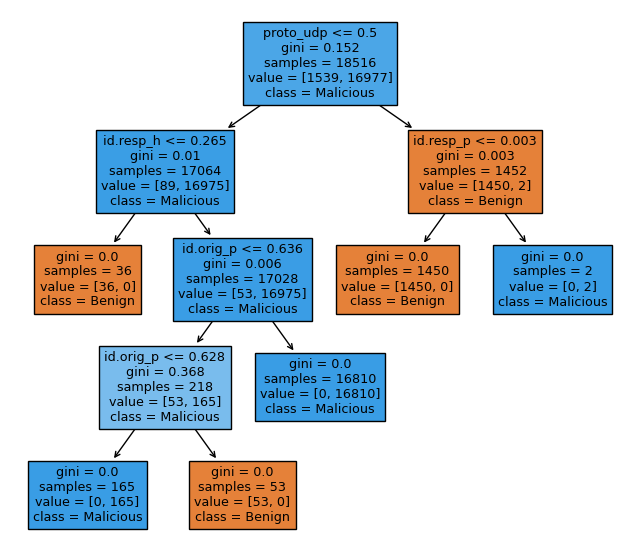

In [87]:
# Visualizing the resulted decision tree (where we notice that only 5 features are the main contributors to classification in this model)
plt.figure(figsize=(8,7))
plot_tree(dt_est, feature_names=list(data_X.columns), class_names=["Benign", "Malicious"], filled=True)
plt.show()